In [ ]:
import os
import re
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)

from typing import Literal

import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider


sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 

os.makedirs('out/figs', exist_ok=True)

print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))


DPI = 600

# def show_pal0(palette):
#     sns.palplot(sns.color_palette(palette, 24))
#     print(palette)
# interact(show_pal0, palette='deep muted pastel bright dark colorblind'.split());

## Table2: Cross Validation

In [ ]:
mm = [
    'Accuracy', 
    'Accuracy(Patch)', 
    'F1 score', 
    'Precision', 
    'Recall', 
]

def dump_to_table(target:Literal['cv', 'ebrains'], coarse=False, result_limit=100):
    r = None
    error_type = 'ci'
    coarse_suffix = '_coarse' if coarse else ''
    P = f'out/figs/table2{coarse_suffix}_{target}.xlsx'
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results{coarse_suffix}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    vv = vvv[m].values
                    mean = np.mean(vv)
                    if error_type == 'ci':
                        ci = stats.t.interval(confidence=0.95, df=len(vv)-1, loc=mean, scale=stats.sem(vv))
                        error = (ci[1] - ci[0])/2
                    else:
                        error = stats.sem(vv)                    
                    s = '{:.3f} ± {:.3f}'.format(mean, error)
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 
    
dump_to_table('cv', True, 500)

In [ ]:
dump_to_table('cv', False, 500)

In [ ]:
dump_to_table('cv', True, 100)

In [ ]:
dump_to_table('cv', False, 100)

In [ ]:
dump_to_table('ebrains', True, 500)

In [ ]:
dump_to_table('ebrains', False, 500)

## fig3: Box - Cross Validation

cv - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_Accuracy(Patch).png


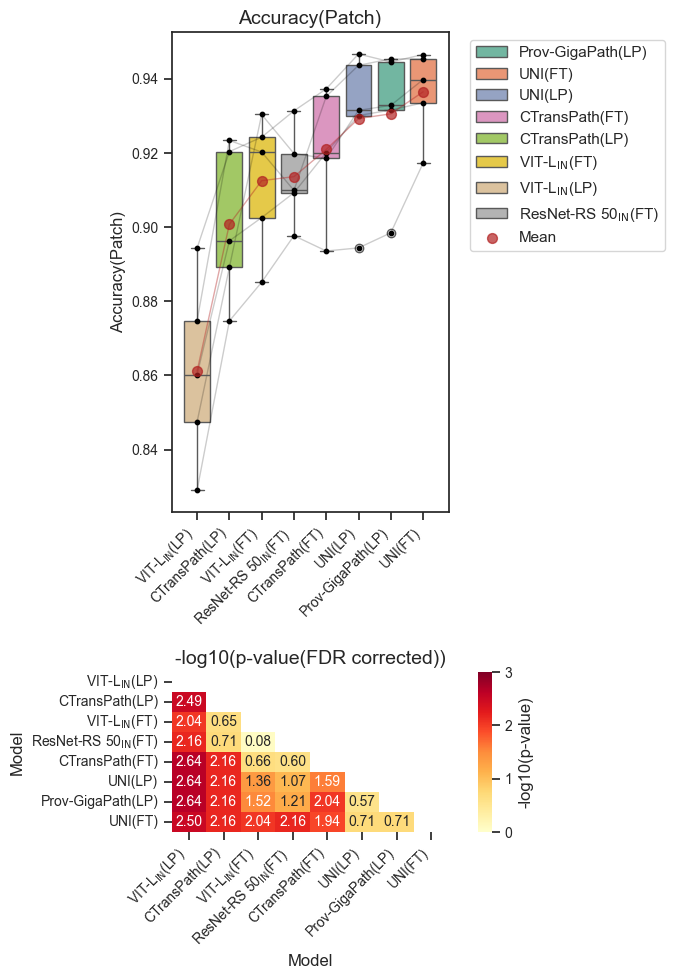

In [49]:
from statsmodels.stats.multitest import multipletests

label_order = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
]

verbose = False

def paired_box(target:Literal['cv', 'ebrains'], coarse:bool, limit:int, key:str,  excludes=['frozen_baseline-cnn']):
    c = 'coarse' if coarse else 'fine'
    key_map = {
        'pacc': 'Accuracy(Patch)',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }
    key_label = key_map[key]
    
    df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    
    labels = df['label'].unique()

    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1], hspace=0.5, wspace=0.2)

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])

    # Box plot
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    sns.boxplot(x='label', hue='label', y=key_label, data=df, legend=True, palette=[color_map[label] for label in labels], ax=ax1)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.2, linewidth=1)
    
    # Scatter individual points
    for i, label in enumerate(labels):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    # Plot mean
    ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)
    mean_scatter = ax1.scatter(range(n_models), df_mean, color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    ax1.set_title(key_label)
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key_label)


    # Calculate p-values
    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels[i]][key_label]
            b = df[df['label']==labels[j]][key_label]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)

    # Benjamini-Hochberg correction
    _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

    # Create significance matrix
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_corrected[k])
            k += 1

    # Create mask for lower triangle
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)

    # Heatmap
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd', 
                          ax=ax2, cbar_ax=cax, cbar_kws={'label': '-log10(p-value)'}, vmin=0.0, vmax=3.0)

    # Set ax2 properties
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.set_yticklabels(labels, rotation=0)
    ax2.set_title('-log10(p-value(FDR corrected))')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')

    # handles, labels = ax1.get_legend_handles_labels()
    # handles = handles[:-1][::-1] + [handles[-1]]
    # labels = labels[:-1][::-1] + [labels[-1]]
    # ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    handles, labels = ax1.get_legend_handles_labels()
    legend_labels = label_order + ['Mean']
    legend_handles = []
    for i, l in enumerate(label_order):
        o = labels.index(l)
        legend_handles.append(handles[o])
    legend_handles += [mean_scatter]
    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(left=0.30, right=0.70, top=0.95, bottom=0.15)

    print(f'{target} - {c} - {limit} - {key}')
    fig_path = f'out/figs/box_cv_{c}_{limit}_{key_label}.png'
    plt.savefig(fig_path, format='png', dpi=DPI)
    print(f'saved {fig_path}')

paired_box('cv', True, 500, 'pacc')

### CV 100 coarse patches/case

In [39]:
paired_box('cv', coarse=True, limit=500, key='Accuracy', verbose=False)
plt.close()

paired_box('cv', coarse=True, limit=500, key='F1 score', verbose=False)
plt.savefig("out/figs/box_cv_coarse_500_f1.png", format="png", dpi=DPI)
plt.close()

cv - coarse - 100 - Accuracy


cv - coarse - 100 - F1 score


### CV 100 fine coarse patches/case

cv - fine - 100 - Accuracy
cv - fine - 100 - F1 score
cv - fine - 100 - Accuracy(Patch)


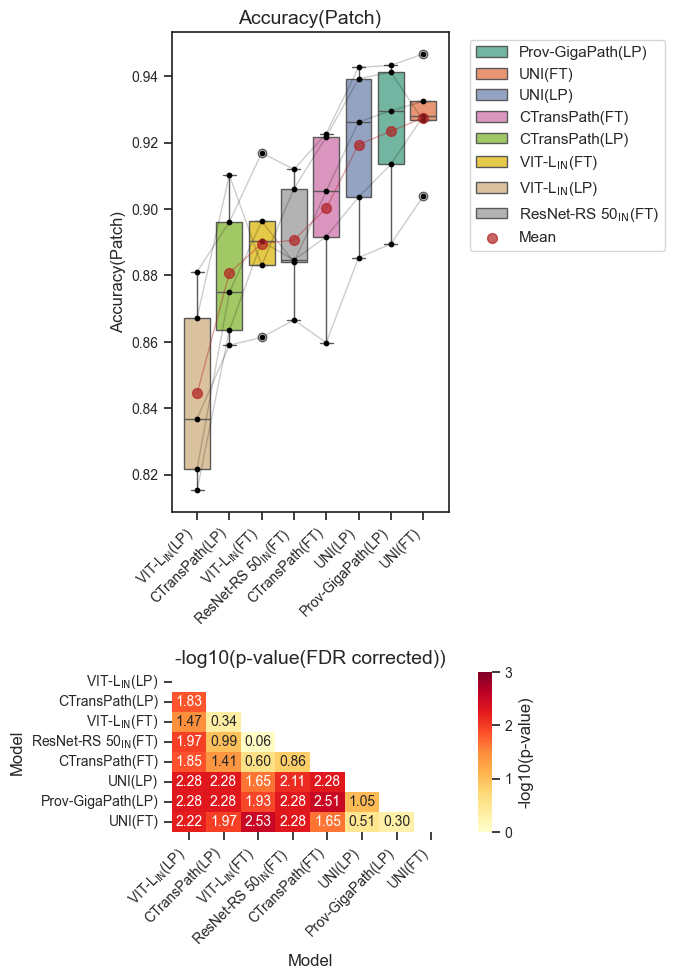

In [43]:
paired_box('cv', coarse=False, limit=100, key='Accuracy', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=DPI)
plt.close()

paired_box('cv', coarse=False, limit=100, key='F1 score', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=DPI)
plt.close()

paired_box('cv', coarse=False, limit=100, key='Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_cv_100_pacc.png", format="png", dpi=DPI)

### EBRAINS coarse 100 patches/case

In [ ]:
paired_box('ebrains', coarse=False, limit=100, target='Accuracy(Patch)', verbose=False)
plt.savefig("out/figs/fig3_ebrains_100_pacc.png", format="png", dpi=300)

In [ ]:
paired_box('ebrains', coarse=False, limit=100, target='Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_100_acc.png", format="png", dpi=DPI)

In [ ]:
paired_box('ebrains', coarse=False, limit=100, target='F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=DPI)
plt.show()

### EBRAINS coarse 10 patches/case

In [ ]:
paired_box('cv', coarse=True, limit=100, key='Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_pacc.png", format="png", dpi=DPI)

In [ ]:
paired_box('ebrains', 10, 'Accuracy', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_acc.png", format="png", dpi=DPI)

In [ ]:
paired_box('ebrains', 10, 'F1 score', verbose=False)
plt.savefig("out/figs/fig3_ebrains_10_f1.png", format="png", dpi=DPI)
plt.show()

#### fig4

This fig shows the impact of patch number per case on model performace

In [ ]:

def draw_lines(target:Literal['cv', 'ebrains'], key:str, labels=None, fill=False, legend=False):
    label_order = [
        'Prov-GigaPath(LP)',
        'UNI(FT)',
        'UNI(LP)',
        'CTransPath(FT)',
        'CTransPath(LP)',
        r'VIT-L$\mathrm{_{IN}}$(FT)',
        r'VIT-L$\mathrm{_{IN}}$(LP)',
        r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
        # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    ]
    
    color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        if labels is None:
            if limit == limits[0]:
                # sort on 10 limit
                df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
                df[f'average_{key}'] = df['label'].map(df_mean)
                df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
                labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(6, 7))
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=label)
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key)
    # plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(key)    
    plt.tight_layout()
    return labels

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    'VIT-L$\\mathrm{_{IN}}$(FT)',
    'VIT-L$\\mathrm{_{IN}}$(LP)',
    'ResNet-RS 50$\\mathrm{_{IN}}$(FT)',
    # 'ResNet-RS 50$\\mathrm{_{IN}}$(LP)',
]
draw_lines('cv', 'Accuracy(Patch)', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_pacc.png", format="png", dpi=DPI)
plt.show()

In [ ]:
draw_lines('cv', 'Accuracy', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_acc.png", format="png", dpi=DPI)
plt.show()

In [ ]:
draw_lines('cv', 'F1 score', labels=labels, fill=False)
plt.savefig(f"out/figs/fig4_cv_f1.png", format="png", dpi=DPI)
plt.show()

### Fig4: EBRAINS - lines

In [ ]:
draw_lines('ebrains', 'Accuracy(Patch)', labels)
plt.savefig(f"out/figs/fig4_ebrains_pacc.png", format="png", dpi=DPI)
plt.show()

In [ ]:
draw_lines('ebrains', 'Accuracy', labels)
plt.savefig(f"out/figs/fig4_ebrains_acc.png", format="png", dpi=DPI)
plt.show()

In [ ]:
draw_lines('ebrains', 'F1 score', labels)
plt.savefig(f"out/figs/fig4_ebrains_f1.png", format="png", dpi=DPI)
plt.show()